In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
import cv2
import os
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
    
AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Point_cloud_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            Point_cloud_small.append(temp_point_cloud)
    return Point_cloud_small
########################点云转RCBD图像############
def PointCloud_to_RGBD(pointCloud_array):
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(pointCloud_array)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.get_render_option().point_color_option = o3d.visualization.PointColorOption.Color
    vis.get_render_option().point_size = 3.0
    vis.add_geometry(pcd)
    Image=vis.capture_screen_float_buffer(do_render=True)
    vis.destroy_window()
    Image_array = np.array(Image)[150:900,580:1320]
    return Image_array
############开始制作数据###################
PointCloud_new =[]
#制作Ground truth
Y_Data=np.zeros((1,12))
###################辅助信息###########################
F_AC13_1 =[1.24,0.63,0.51,-0.48,3.61,-2.33,-0.41,-0.07,0.16,0.42,1.68,0.87]
F_AC13_2 =[1.26,0.59,0.45,-0.56,3.58,-1.96,-0.33,-0.03,0.18,0.39,1.72,0.91]
F_AC16_3 =[0.92,0.77,0.76,-0.93,4.06,-3.38,-0.49, 0.02,0.36,0.68,1.28,0.93]
F_AC16_4 =[1.27,0.87,0.96,-0.75,3.74,-4.47,-0.64,-0.04,0.45,0.90,1.78,1.04]
F_UT5_1  =[0.49,0.54,0.39,-1.44,7.12,-3.55,-0.17, 0.06,0.21,0.34,0.72,0.63]
F_UT5_2  =[0.53,0.56,0.40,-1.13,5.12,-2.49,-0.24, 0.03,0.21,0.35,0.75,0.71]
F_UT5_3  =[0.49,0.54,0.39,-1.44,7.12,-3.55,-0.17, 0.06,0.21,0.34,0.72,0.63]
F_UT5_4  =[0.53,0.56,0.40,-1.13,5.12,-2.49,-0.24, 0.03,0.21,0.35,0.75,0.71]
F_SMA13_1=[1.33,1.04,1.35,-0.93,4.07,-6.09,-0.63, 0.30,0.82,1.28,2.05,0.95]
F_SMA13_2=[1.42,1.00,1.29,-1.33,5.75,-7.60,-0.74, 0.17,0.71,1.12,2.05,1.05]
F_OGFC10 =[1.77,0.77,0.75,-0.97,4.77,-4.47,-0.44, 0.08,0.39,0.66,2.41,1.52]
Aided_information = np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    #print(len(temp))
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0): 
        temp2 = np.full((len(temp),12),AC13)
        temp3 = np.full((len(temp),12),F_AC13_1)
    elif (i==1):
        temp2 = np.full((len(temp),12),AC13)
        temp3 = np.full((len(temp),12),F_AC13_2)
    elif (i==2):
        temp2 = np.full((len(temp),12),AC16)
        temp3 = np.full((len(temp),12),F_AC16_3)
    elif (i==3):
        temp2 = np.full((len(temp),12),AC16)
        temp3 = np.full((len(temp),12),F_AC16_4)
    elif (i==4):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_1)
    elif (i==5):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_2)
    elif (i==6):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_3)
    elif (i==7):
        temp2 = np.full((len(temp),12),UT5)
        temp3 = np.full((len(temp),12),F_UT5_4)
    elif (i==8):
        temp2 = np.full((len(temp),12),SMA13)
        temp3 = np.full((len(temp),12),F_SMA13_1)
    elif (i==9):
        temp2 = np.full((len(temp),12),SMA13)
        temp3 = np.full((len(temp),12),F_SMA13_2)     
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10)
        temp3 = np.full((len(temp),12),F_OGFC10)  
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    Aided_information = np.concatenate((Aided_information,temp3),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
Aided_information = np.delete(Aided_information, 1, 0)#把第一行0删掉
print(Y_Data.shape)
print(Aided_information.shape)
Image_set=[]
for i in range(len(PointCloud_new )):
    temp = PointCloud_to_RGBD(PointCloud_new[i])
    Image_set.append(temp)
Image_set=np.array(Image_set)
print(Image_set.shape)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1579, 12)
(1579, 12)
(1579, 750, 740, 3)


In [3]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X1_Data = []
Train_X2_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X1_Data.append(Image_set[r[i]])
    Train_X2_Data.append(Aided_information[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X1_Data = []
Test_X2_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X1_Data.append(Image_set[r[i]])
    Test_X2_Data.append(Aided_information[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X1_Data = np.array(Train_X1_Data)
Train_X2_Data = np.array(Train_X2_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X1_Data = np.array(Test_X1_Data)
Test_X2_Data = np.array(Test_X2_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X1_Data.shape)
print(Train_X2_Data.shape)
print(Train_Y_Data.shape)
print(Test_X1_Data.shape)
print(Test_X2_Data.shape)
print(Test_Y_Data.shape)

(1379, 750, 740, 3)
(1379, 12)
(1379, 12)
(200, 750, 740, 3)
(200, 12)
(200, 12)


In [4]:
#googlenet
class Inception(tf.keras.layers.Layer):
    def __init__(self,c1, c2, c3, c4):
        super().__init__()
        # 线路1，单1 x 1卷积层
        self.p1_1 = tf.keras.layers.Conv2D(c1, kernel_size=1, activation='relu', padding='same')
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], kernel_size=1, padding='same', activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], kernel_size=3, padding='same',
                              activation='relu')
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], kernel_size=1, padding='same', activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], kernel_size=5, padding='same',
                              activation='relu')
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = tf.keras.layers.MaxPool2D(pool_size=3, padding='same', strides=1)
        self.p4_2 = tf.keras.layers.Conv2D(c4, kernel_size=1, padding='same', activation='relu')
        
        self.BN = tf.keras.layers.BatchNormalization()

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        p5 = tf.concat([p1, p2, p3, p4], axis=-1)  # 在通道维上连结输出
        p6 = self.BN(p5)
        return p6

def GoogleNet(num_classes):
    input_layer1 = tf.keras.Input(shape=(750, 740, 3),
                              name='input_points')  #图像
    input_layer2 = tf.keras.Input(shape=(12),
                              name='aided_information')  #添加辅助信息
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer1)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(192, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = Inception(64, (96, 128), (16, 32), 32)(x)
    x = Inception(128, (128, 192), (32, 96), 64)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = Inception(192, (96, 208), (16, 48), 64)(x)
    x = Inception(160, (112, 224), (24, 64), 64)(x)
    x = Inception(128, (128, 256), (24, 64), 64)(x)
    x = Inception(112, (144, 288), (32, 64), 64)(x)
    x = Inception(256, (160, 320), (32, 128), 128)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = Inception(256, (160, 320), (32, 128), 128)(x)
    x = Inception(384, (192, 384), (48, 128), 128)(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(256,activation='relu')(x)
    
    Fx = tf.keras.layers.Dense(256,activation='relu')(input_layer2)
    Fx = tf.keras.layers.BatchNormalization()(Fx)
    Fx = tf.keras.layers.Dense(256,activation='relu')(Fx)
    
    x =  tf.keras.layers.concatenate([x,Fx],axis=-1)
    x =  tf.keras.layers.Dense(256,activation='relu')(x)
    output_layer =  tf.keras.layers.Dense(num_classes,activation='relu')(x)
    
    net = tf.keras.Model(inputs=[input_layer1,input_layer2], outputs=output_layer)
    return net

In [ ]:
Batch_size=8
model = GoogleNet(num_classes=12)
model.build(input_shape=(None, 750, 740, 3))
model.summary()
lr=1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = tf.keras.callbacks.ModelCheckpoint("GoogleNet-辅助信息.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=model.fit(x=[Train_X1_Data,Train_X2_Data],y=Train_Y_Data,batch_size=Batch_size,epochs =200, validation_split=0.2, callbacks=Callback)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_points (InputLayer)       [(None, 750, 740, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 375, 370, 64) 9472        input_points[0][0]               
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 188, 185, 64) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 188, 185, 64) 4160        max_pooling2d_13[0][0]           
____________________________________________________________________________________________

138/138 [==============================] - 16s 115ms/step - loss: 0.0999 - val_loss: 0.1502
Epoch 98/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0969 - val_loss: 0.0648
Epoch 99/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0757 - val_loss: 0.0961
Epoch 100/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0863 - val_loss: 0.1467
Epoch 101/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0867 - val_loss: 0.0906
Epoch 102/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0831 - val_loss: 0.1415ETA: 0s - loss:
Epoch 103/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0880 - val_loss: 0.1326 - loss: 0.0 - ETA:  - ETA: 4s - lo - ETA - ETA: 
Epoch 104/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0846 - val_loss: 0.1243A - ETA: 10s 
Epoch 105/200
138/138 [==============================] - 16s 115ms/step - loss: 0.0843 - va

In [ ]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/GoogleNet_辅助信息.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save() 

7/7 [==============================] - 2s 113ms/step - loss: 0.0463


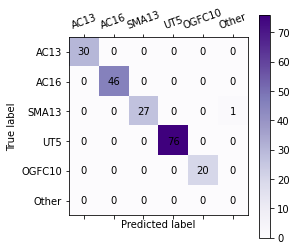

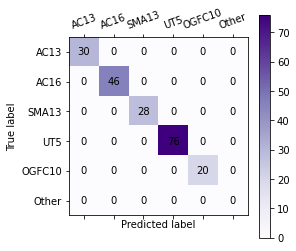

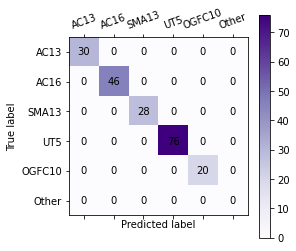

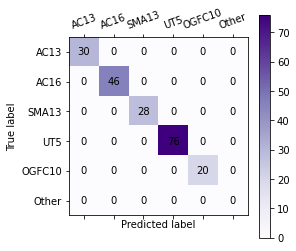

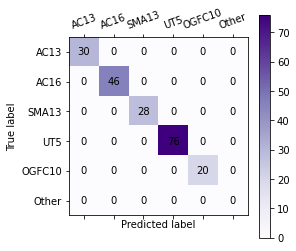

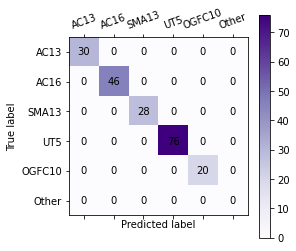

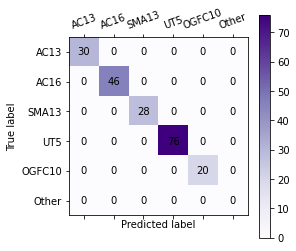

In [9]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

Batch_size=8
model = GoogleNet(num_classes=12)
model.build(input_shape=(None, 750, 740, 3))
lr=1e-3
model.load_weights("GoogleNet-辅助信息.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
model.evaluate([Test_X1_Data,Test_X2_Data],Test_Y_Data)
Thr_list = [0.1,0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X1_Data)):
        R,P=identification(model([np.array(Test_X1_Data[i])[np.newaxis,...],np.array(Test_X2_Data[i])[np.newaxis,...]])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Purples) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/GoogleNet_conv2D'+str(Thr)+'.png',dpi=600)#保存图片
    plt.show()